In [1]:
import os
from google.colab import files
import torchvision
import glob
from torchvision import transforms
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
import zipfile

#Data preproceccing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_path = '/content/drive/MyDrive/Colab_Notebooks/datasets/stm-data/stm-data.zip'
z = zipfile.ZipFile(zip_path, 'r')
z.extractall()
print(os.listdir())

['.config', 'drive', 'stm-data', 'sample_data']


In [4]:
path = '/content/stm-data/JointDataset'
train_bad_dir = path + '/Train/bad'
train_good_dir = path + '/Train/good'
test_bad_dir = path + '/Test/bad'
test_good_dir = path + '/Test/good'

train_bad_names = glob.glob(train_bad_dir + '/*.npy')
train_good_names = glob.glob(train_good_dir + '/*.npy')
test_bad_names = glob.glob(test_bad_dir + '/*.npy')
test_good_names = glob.glob(test_good_dir + '/*.npy')
all_names = [train_bad_names, train_good_names, test_bad_names, test_good_names]

#Preparing batches

In [32]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, names, y, transform = None):
        self.names = names
        self.y = y
        if transform is None:
            self.should_transform = False
        else:
            self.transform = transform
            self.should_transform = True

    def __len__(self):
        return len(self.names)

    def __getitem__(self,idx):
        self.mas = np.load(self.names[idx])

        if self.should_transform:
            self.mas_transformed = self.transform(self.mas)
        else:
            self.mas_transformed = self.mas
        return self.mas_transformed.float(), self.y

In [34]:
transform = torchvision.transforms.Compose([           
    transforms.ToTensor(),                        
    transforms.Normalize([0.45],[0.2])                                       
    ])


#bad: y=0
#good: y=1
train_bad_dataset = MyDataset(names=train_bad_names, y=0, transform=transform)
train_good_dataset = MyDataset(names=train_good_names, y=1, transform=transform)
train_dataset = train_bad_dataset + train_good_dataset

test_bad_dataset = MyDataset(names=test_bad_names, y=0, transform=transform)
test_good_dataset = MyDataset(names=test_good_names, y=1, transform=transform)
test_dataset = test_bad_dataset + test_good_dataset

In [37]:
test_bad_dataset[0][0].shape

torch.Size([1, 64, 64])

In [38]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
#torch.Size([batch_size,channels,64,64])

#Stating models 

In [39]:
class Le_net(torch.nn.Module):
    def __init__(self):
        super(Le_net, self).__init__()
        #in 1*64*64
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.conv2 = nn.Conv2d(4,8,3)
        self.act1=nn.ReLU()
        self.max_pool1=nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.act2 = nn.ReLU()
        #out 8*30*30

        #in 8*30*30
        self.conv3 = nn.Conv2d(8, 8, 3)
        self.conv4 = nn.Conv2d(8, 16, 3)
        self.act3 = nn.ReLU()
        self.max_pool2=nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.25)
        self.act4 = nn.ReLU()
        #out 16*13*13

        #Flatten in forward function
        self.fc1 = nn.Linear(16*13*13, 100)
        self.act5 = nn.ReLU()
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(100, 2)
        #last activation in forward function

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.act1(x)
        x = self.max_pool1(x)
        x = self.dropout1(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.act3(x)
        x = self.max_pool2(x)
        x = self.dropout2(x)
        x = self.act4(x)

        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.act5(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x

#Train-Test procedures

In [40]:
def train(model, train_loader, epochs, optimizer):
    model.train()
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for data,target in train_loader:
            data=data.to(device)
            target=target.to(device)
            optimizer.zero_grad()   # zero the gradient buffers
            output = model.forward(data)
            
            loss = F.nll_loss(output, target)
            loss.backward()
            loss_samples.append(loss.data.cpu().numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

In [44]:
def test(model, device, test_loader):
    model.eval()
    loss=0
    accuracy = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:

            
            data, target = data.to(device), target.to(device)
            output = model.forward(data)
            loss+= F.nll_loss(output,target)
            pred = output.argmax(dim=1, keepdim=True)
            

            
            target = target.view_as(pred)
            for i,single_pred in enumerate(pred):
                if single_pred == target[i]:
                    correct+= 1
            total += len(pred)
    loss = loss/len(test_loader)
    accuracy = correct / total
    
    print('Loss: ',loss.data.item())
    print('\n Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, total, 100. * accuracy))

#Main loop

In [45]:
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)



#Choose model below
model = Le_net().to(device)


cuda


Epoch        0 Loss: 0.5558882377626725
Epoch        1 Loss: 0.5404174037600491
Epoch        2 Loss: 0.5405107381252142
Epoch        3 Loss: 0.5408277960344293
Epoch        4 Loss: 0.5404027946800599
Epoch        5 Loss: 0.540443989394725
Epoch        6 Loss: 0.5402984321776162
Epoch        7 Loss: 0.5401092976147258
Epoch        8 Loss: 0.5406078875302004
Epoch        9 Loss: 0.5404697848989519


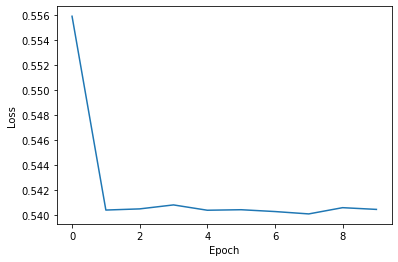

Выходные данные были обрезаны до нескольких последних строк (5000).
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
tensor([[1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [1],
        [1],
        [0],
     

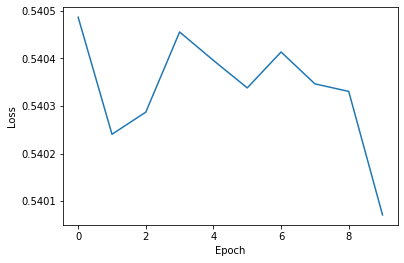

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        

KeyboardInterrupt: ignored

In [46]:
#Main loop train epochs_train times and test once and
#repeat it train_cycles times
train_cycles=3
epochs_train=10
lr=10e-3
#Main loop
for i in range(train_cycles):
    train(model=model, train_loader=train_loader, epochs=epochs_train, optimizer=optim.Adam(model.parameters(), lr=lr))
    test(model=model,device=device,test_loader=test_loader)